**// IMPORTS**

In [3]:
import pandas as pd
import duckdb, pandas as pd, re
from collections import Counter
import matplotlib.pyplot as plt
from sacrebleu import corpus_bleu, corpus_chrf
import numpy as np

**// CONFIGS**

In [ ]:
DB_PATH = '../data/duckdb/subs.duckdb'
TABLE   = "opus_moses_filtered"
N_RATIO_SAMPLE   = 50_000   # for ratio histogram
N_SCATTER_SAMPLE = 200_000   # for scatter plot
N_QUALITY_SAMPLE = 300_000    # for BLEU/quality metrics


pd.set_option("display.max_colwidth", None)

**// MAIN CODE**

In [3]:
con = duckdb.connect(DB_PATH)

# ---------- BASIC INFO ----------
print("=== BASIC INFO ===")
info = con.execute(f"""
    SELECT COUNT(*) AS total_rows,
           COUNT(DISTINCT sent_pt_br) AS unique_br,
           COUNT(DISTINCT sent_pt_pt) AS unique_pt
    FROM {TABLE};
""").fetchdf()
print(info)

=== BASIC INFO ===


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   total_rows  unique_br  unique_pt
0    10510013    9461055    9495300


In [4]:
basic = con.execute(f"""
SELECT
  COUNT(*)                                     AS total_rows,
  SUM(sent_pt_br IS NULL)                      AS null_br,
  SUM(sent_pt_pt IS NULL)                      AS null_pt,
  SUM(COALESCE(TRIM(sent_pt_br),'')='')        AS empty_br,
  SUM(COALESCE(TRIM(sent_pt_pt),'')='')        AS empty_pt,
  COUNT(DISTINCT sent_pt_br)                   AS unique_br_raw,
  COUNT(DISTINCT sent_pt_pt)                   AS unique_pt_raw
FROM {TABLE};
""").fetchdf()

# --- NORMALIZED VIEW IN-QUERY (lower + trim + squeeze spaces) ---
norm = con.execute(f"""
WITH n AS (
  SELECT
    LOWER(TRIM(REGEXP_REPLACE(sent_pt_br,'\\s+',' '))) AS br,
    LOWER(TRIM(REGEXP_REPLACE(sent_pt_pt,'\\s+',' '))) AS pt
  FROM {TABLE}
  WHERE sent_pt_br IS NOT NULL AND sent_pt_pt IS NOT NULL
)
SELECT
  COUNT(*)                                              AS rows_2sides,
  COUNT(DISTINCT br)                                    AS unique_br_norm,
  COUNT(DISTINCT pt)                                    AS unique_pt_norm,
  COUNT(DISTINCT br || CHR(31) || pt)                   AS unique_pairs_norm,
  COUNT(*) - COUNT(DISTINCT br || CHR(31) || pt)        AS dup_pairs_norm
FROM n;
""").fetchdf()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [5]:
concat = pd.concat([basic, norm], axis=1)
concat

,total_rows,null_br,null_pt,empty_br,empty_pt,unique_br_raw,unique_pt_raw,rows_2sides,unique_br_norm,unique_pt_norm,unique_pairs_norm,dup_pairs_norm
0,10510013,0.0,0.0,0.0,0.0,9461055,9495300,10510013,9447883,9483033,10487155,22858



=== LENGTH STATS ===
             len_br        len_pt
count  1.051001e+07  1.051001e+07
mean   3.972676e+01  3.991568e+01
std    3.028665e+01  3.034423e+01
min    1.000000e+00  1.000000e+00
25%    2.100000e+01  2.100000e+01
50%    3.100000e+01  3.100000e+01
75%    4.900000e+01  5.000000e+01
max    2.804000e+03  2.778000e+03


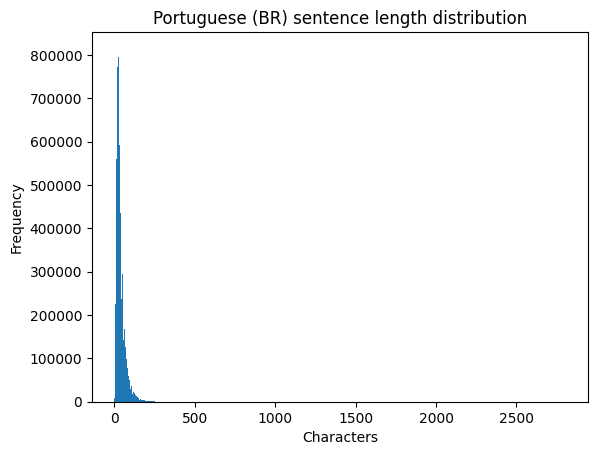

,len_br,len_pt
0,244,239
1,12,9
2,33,24
3,14,13
4,81,92
...,...,...
10510008,29,29
10510009,72,69
10510010,52,49
10510011,42,35


In [6]:
# ---------- LENGTH DISTRIBUTION ----------
print("\n=== LENGTH STATS ===")
lengths = con.execute(f"""
    SELECT
        length(sent_pt_br) AS len_br,
        length(sent_pt_pt) AS len_pt
    FROM {TABLE}
    WHERE sent_pt_br IS NOT NULL AND sent_pt_pt IS NOT NULL;
""").fetchdf()

print(lengths.describe())

plt.hist(lengths["len_br"], bins=1000)
plt.title("Portuguese (BR) sentence length distribution")
plt.xlabel("Characters"); plt.ylabel("Frequency")
plt.show()

lengths

In [7]:
# helper to tokenize quickly
def tokenize(text):
    return re.findall(r"\b\w+\b", text.lower())

# sample ~10000 random rows for text statistics (for speed)
sample_texts = con.execute(f"""
    SELECT sent_pt_br, sent_pt_pt
    FROM {TABLE}
    USING SAMPLE 10000
""").fetchdf()

tokens_br = []
tokens_pt = []
for _, row in sample_texts.iterrows():
    if row.sent_pt_br: tokens_br += tokenize(row.sent_pt_br)
    if row.sent_pt_pt: tokens_pt += tokenize(row.sent_pt_pt)

vocab_br = set(tokens_br)
vocab_pt = set(tokens_pt)

print("\n=== VOCABULARY ===")
print(f"Total tokens (BR): {len(tokens_br):,}")
print(f"Unique tokens (BR): {len(vocab_br):,}")
print(f"Type-token ratio (BR): {len(vocab_br)/len(tokens_br):.4f}")

print(f"Total tokens (PT): {len(tokens_pt):,}")
print(f"Unique tokens (PT): {len(vocab_pt):,}")
print(f"Type-token ratio (PT): {len(vocab_pt)/len(tokens_pt):.4f}")

# most common words
print("\nTop 20 BR words:")
for w,c in Counter(tokens_br).most_common(20):
    print(f"{w:>12} : {c}")



=== VOCABULARY ===
Total tokens (BR): 73,217
Unique tokens (BR): 11,623
Type-token ratio (BR): 0.1587
Total tokens (PT): 74,724
Unique tokens (PT): 11,919
Type-token ratio (PT): 0.1595

Top 20 BR words:
         que : 2481
           o : 2148
         não : 1937
          de : 1740
           a : 1696
           é : 1346
           e : 1203
        você : 1151
          eu : 1066
          um : 909
        para : 800
          se : 785
         uma : 657
        está : 637
         com : 607
          me : 598
         ele : 567
         por : 551
          em : 527
          do : 499


     n_rows  avg_ratio  median_ratio  n_strict_ok  n_loose_ok  n_outliers  \
0  10510013   1.030116           1.0    8450180.0  10347894.0    162119.0   

   corr_len  pct_strict_ok  pct_loose_ok  pct_outliers  
0  0.962905       0.804012      0.984575      0.015425  


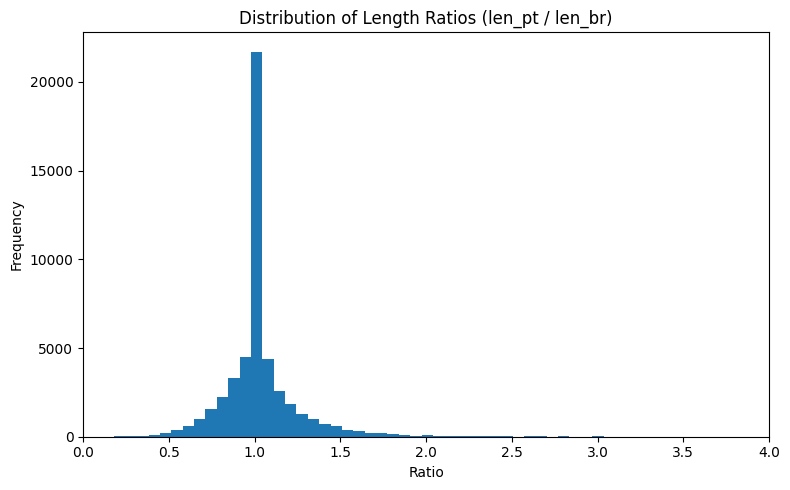

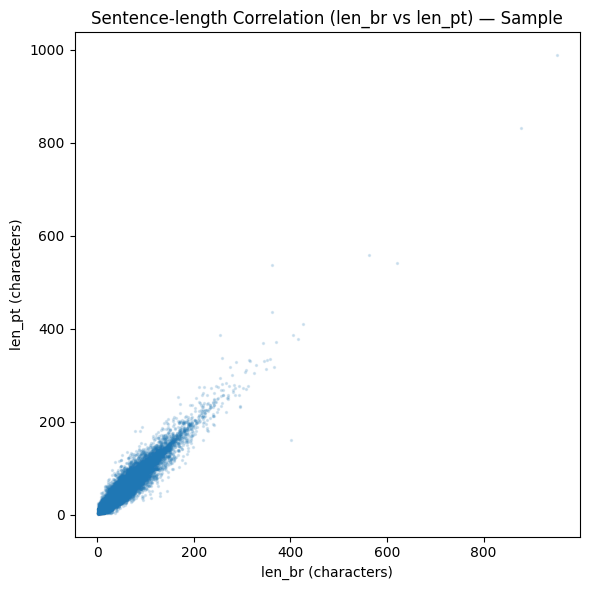

In [45]:
ratio_stats = con.execute(f"""
WITH L AS (
  SELECT
    LENGTH(sent_pt_br) AS lb,
    LENGTH(sent_pt_pt) AS lp
  FROM {TABLE}
  WHERE sent_pt_br IS NOT NULL
    AND sent_pt_pt IS NOT NULL
    AND LENGTH(sent_pt_br) > 0
)
SELECT
  COUNT(*)                                                   AS n_rows,
  AVG(lp::DOUBLE / lb)                                       AS avg_ratio,
  QUANTILE_CONT(lp::DOUBLE / lb, 0.50)                       AS median_ratio,
  SUM(CASE WHEN (lp::DOUBLE / lb) BETWEEN 0.80 AND 1.25 THEN 1 ELSE 0 END) AS n_strict_ok,
  SUM(CASE WHEN (lp::DOUBLE / lb) BETWEEN 0.50 AND 2.00 THEN 1 ELSE 0 END) AS n_loose_ok,
  SUM(CASE WHEN (lp::DOUBLE / lb) < 0.50 OR (lp::DOUBLE / lb) > 2.00 THEN 1 ELSE 0 END) AS n_outliers,
  CORR(lb, lp)                                               AS corr_len
FROM L;
""").fetchdf()

n_rows = int(ratio_stats.loc[0, "n_rows"])
ratio_stats["pct_strict_ok"] = ratio_stats["n_strict_ok"] / n_rows
ratio_stats["pct_loose_ok"]  = ratio_stats["n_loose_ok"]  / n_rows
ratio_stats["pct_outliers"]  = ratio_stats["n_outliers"]  / n_rows
print(ratio_stats)

# ========= 2) Ratio histogram (sampled) =========
ratio_sample = con.execute(f"""
SELECT
  (LENGTH(sent_pt_pt)::DOUBLE / NULLIF(LENGTH(sent_pt_br),0)) AS ratio
FROM {TABLE}
WHERE sent_pt_br IS NOT NULL AND sent_pt_pt IS NOT NULL AND LENGTH(sent_pt_br) > 0
USING SAMPLE {N_RATIO_SAMPLE} ROWS;
""").df()

plt.figure(figsize=(8,5))
plt.hist(ratio_sample["ratio"].dropna(), bins=150)  # no explicit colors/styles
plt.title("Distribution of Length Ratios (len_pt / len_br)")
plt.xlim(0, 4)
plt.xlabel("Ratio")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# ========= 3) Scatter: len_br vs len_pt (sampled) =========
scatter_sample = con.execute(f"""
SELECT
  LENGTH(sent_pt_br) AS len_br,
  LENGTH(sent_pt_pt) AS len_pt
FROM {TABLE}
WHERE sent_pt_br IS NOT NULL AND sent_pt_pt IS NOT NULL
USING SAMPLE {N_SCATTER_SAMPLE} ROWS;
""").df()

plt.figure(figsize=(6,6))
plt.scatter(scatter_sample["len_br"], scatter_sample["len_pt"], s=2, alpha=0.15)
plt.title("Sentence-length Correlation (len_br vs len_pt) — Sample")
plt.xlabel("len_br (characters)")
plt.ylabel("len_pt (characters)")
plt.tight_layout()
plt.show()

In [9]:
# # Sample for quality metrics
# quality_sample = con.execute(f"""
#     SELECT sent_pt_br, sent_pt_pt
#     FROM {TABLE}
#     WHERE sent_pt_br IS NOT NULL 
#       AND sent_pt_pt IS NOT NULL
#       AND LENGTH(sent_pt_br) > 0
#       AND LENGTH(sent_pt_pt) > 0
#     USING SAMPLE {N_QUALITY_SAMPLE} ROWS
# """).fetchdf()

# print(f"\nUsing sample of {len(quality_sample):,} sentence pairs for quality metrics")

# # ---------- 1. BLEU & chrF SCORES ----------
# print("\n--- 1. BLEU & chrF Scores ---")
# print("(Higher scores = more similar variants = easier translation task)")

# hypotheses = list(quality_sample['sent_pt_br'])
# references = [list(quality_sample['sent_pt_pt'])]  # sacrebleu expects list of references

# bleu_score = corpus_bleu(hypotheses, references)
# chrf_score = corpus_chrf(hypotheses, references)

# print(f"\nBLEU score: {bleu_score.score:.2f}")
# print(f"chrF score: {chrf_score.score:.2f}")
# print(f"\nInterpretation:")
# print(f"  - BLEU {bleu_score.score:.1f}: ", end="")
# if bleu_score.score > 70:
#     print("Very high similarity (variants are very close)")
# elif bleu_score.score > 50:
#     print("High similarity (good parallel corpus)")
# elif bleu_score.score > 30:
#     print("Moderate similarity (typical for close variants)")
# else:
#     print("Low similarity (significant differences between variants)")

# # ---------- 2. VOCABULARY COVERAGE ----------
# print("\n--- 2. Vocabulary Coverage ---")
# print("(Measures lexical overlap between PT-BR and PT-PT)")

# # Tokenize full sample
# all_tokens_br = []
# all_tokens_pt = []
# for _, row in quality_sample.iterrows():
#     all_tokens_br.extend(tokenize(row.sent_pt_br))
#     all_tokens_pt.extend(tokenize(row.sent_pt_pt))

# vocab_br_full = set(all_tokens_br)
# vocab_pt_full = set(all_tokens_pt)

# # Coverage calculations
# overlap = vocab_br_full & vocab_pt_full
# br_only = vocab_br_full - vocab_pt_full
# pt_only = vocab_pt_full - vocab_br_full

# coverage_br_in_pt = len(overlap) / len(vocab_br_full) * 100
# coverage_pt_in_br = len(overlap) / len(vocab_pt_full) * 100

# print(f"\nVocabulary sizes:")
# print(f"  PT-BR unique tokens: {len(vocab_br_full):,}")
# print(f"  PT-PT unique tokens: {len(vocab_pt_full):,}")
# print(f"  Shared tokens: {len(overlap):,}")
# print(f"  BR-only tokens: {len(br_only):,}")
# print(f"  PT-only tokens: {len(pt_only):,}")

# print(f"\nCoverage:")
# print(f"  PT-BR covered by PT-PT: {coverage_br_in_pt:.2f}%")
# print(f"  PT-PT covered by PT-BR: {coverage_pt_in_br:.2f}%")

# # Show some unique tokens
# print(f"\nExample BR-only tokens (10 random):")
# print(f"  {', '.join(list(br_only)[:10])}")
# print(f"\nExample PT-only tokens (10 random):")
# print(f"  {', '.join(list(pt_only)[:10])}")

# # ---------- 3. VOCABULARY GROWTH CURVES ----------
# print("\n--- 3. Vocabulary Growth Curves ---")
# print("(Shows vocabulary diversity as corpus size increases)")

# def calculate_vocab_growth_efficient(tokens, sample_points=10):
#     """Calculate vocabulary size at different corpus sizes - memory efficient"""
#     vocab_sizes = []
#     corpus_sizes = []
    
#     # Create sample points (logarithmic spacing)
#     total = len(tokens)
#     # Start from 100 tokens minimum
#     min_idx = min(100, total // 100)
#     indices = np.logspace(np.log10(min_idx), np.log10(total), sample_points, dtype=int)
#     indices = np.unique(indices)
    
#     vocab_accumulated = set()
#     last_idx = 0
    
#     for idx in indices:
#         # Only process new tokens since last checkpoint
#         new_tokens = tokens[last_idx:idx]
#         vocab_accumulated.update(new_tokens)
        
#         corpus_sizes.append(idx)
#         vocab_sizes.append(len(vocab_accumulated))
#         last_idx = idx
        
#         # Free memory
#         del new_tokens
    
#     return corpus_sizes, vocab_sizes

# print("\nCalculating vocab growth curves (this may take a minute)...")

# # Calculate growth curves with reduced sample points
# corpus_sizes_br, vocab_sizes_br = calculate_vocab_growth_efficient(all_tokens_br, sample_points=10)
# corpus_sizes_pt, vocab_sizes_pt = calculate_vocab_growth_efficient(all_tokens_pt, sample_points=10)

# print("✓ Vocab growth calculation complete")

# # Plot vocabulary growth
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(corpus_sizes_br, vocab_sizes_br, label='PT-BR', linewidth=2, alpha=0.8)
# plt.plot(corpus_sizes_pt, vocab_sizes_pt, label='PT-PT', linewidth=2, alpha=0.8)
# plt.xlabel('Number of tokens')
# plt.ylabel('Vocabulary size')
# plt.title('Vocabulary Growth Curve')
# plt.legend()
# plt.grid(True, alpha=0.3)

# plt.subplot(1, 2, 2)
# plt.plot(corpus_sizes_br, vocab_sizes_br, label='PT-BR', linewidth=2, alpha=0.8)
# plt.plot(corpus_sizes_pt, vocab_sizes_pt, label='PT-PT', linewidth=2, alpha=0.8)
# plt.xlabel('Number of tokens')
# plt.ylabel('Vocabulary size')
# plt.title('Vocabulary Growth Curve (log scale)')
# plt.xscale('log')
# plt.yscale('log')
# plt.legend()
# plt.grid(True, alpha=0.3, which='both')

# plt.tight_layout()
# plt.show()

# # Calculate growth rates
# final_ratio_br = vocab_sizes_br[-1] / corpus_sizes_br[-1]
# final_ratio_pt = vocab_sizes_pt[-1] / corpus_sizes_pt[-1]

# print(f"\nVocabulary growth characteristics:")
# print(f"  PT-BR final vocab/token ratio: {final_ratio_br:.4f}")
# print(f"  PT-PT final vocab/token ratio: {final_ratio_pt:.4f}")
# print(f"\nInterpretation:")
# print(f"  - Curves that plateau = limited vocabulary diversity")
# print(f"  - Steep curves = high lexical diversity")
# print(f"  - Similar curves = balanced corpus")

# # ---------- SUMMARY ----------
# print("\n" + "="*60)
# print("=== QUALITY SUMMARY ===")
# print("="*60)
# print(f"""
# Corpus Quality Assessment:
# --------------------------
# 1. Similarity: BLEU={bleu_score.score:.1f}, chrF={chrf_score.score:.1f}
#    → {'High' if bleu_score.score > 50 else 'Moderate' if bleu_score.score > 30 else 'Low'} similarity between variants

# 2. Coverage: {min(coverage_br_in_pt, coverage_pt_in_br):.1f}% shared vocabulary
#    → {'Excellent' if min(coverage_br_in_pt, coverage_pt_in_br) > 80 else 'Good' if min(coverage_br_in_pt, coverage_pt_in_br) > 60 else 'Moderate'} lexical overlap

# 3. Diversity: {len(vocab_br_full):,} (BR) vs {len(vocab_pt_full):,} (PT) unique tokens
#    → {'Balanced' if 0.8 < len(vocab_br_full)/len(vocab_pt_full) < 1.2 else 'Imbalanced'} vocabulary sizes

# Overall: This corpus is suitable for fine-tuning a PT-BR ↔ PT-PT translation model.
# """)

In [9]:
import duckdb, pandas as pd, pathlib
from typing import Iterable, Optional

# ---------------------------------------------------------
# CONFIG
# ---------------------------------------------------------
DB_PATH = "../data/duckdb/subs.duckdb"
TABLE   = "opus_moses_filtered"

# Helpful PRAGMAs (tune to your box)
PRAGMA_THREADS = 8
PRAGMA_MEM     = "4GB"   # e.g., "2GB", "6GB"

# ---------------------------------------------------------
# UTIL
# ---------------------------------------------------------
def _connect(db_path: str):
    con = duckdb.connect(db_path)
    con.execute(f"PRAGMA threads={PRAGMA_THREADS};")
    con.execute(f"PRAGMA memory_limit='{PRAGMA_MEM}';")
    return con

def ensure_token_macro(con: duckdb.DuckDBPyConnection) -> None:
    # ASCII apostrophe must be written as two single quotes inside SQL:  '' 
    con.execute("""
        CREATE OR REPLACE MACRO token_re() AS
        '(?:[A-Za-zÀ-ÖØ-öø-ÿ]+(?:[-’''][A-Za-zÀ-ÖØ-öø-ÿ]+)*)';
    """)
    # quick sanity check — should return 3 tokens: ['Olá-mundo','d’água','hoje']
    con.execute("SELECT REGEXP_EXTRACT_ALL('Olá-mundo d’água hoje', token_re())").fetchall()

# ----------------------------
# 1) WORD FREQUENCY GAP (pt_BR vs pt_PT) — uses token_re() macro
# ----------------------------
def word_frequency_gap(
    db_path: str = DB_PATH,
    table: str = TABLE,
    min_count: int = 50,
    stopwords: Optional[Iterable[str]] = None,
    top_n: int = 1000,
    out_csv: Optional[str] = "word_diff_top.csv",
) -> pd.DataFrame:
    """
    Computes BR/PT word frequencies over the FULL dataset (no sampling),
    normalizes to per-million, and returns the top tokens by |Δ freq|.
    - Optional stopwords
    - Filters tokens with combined raw count >= min_count
    """
    con = _connect(db_path)
    ensure_token_macro(con)

    if stopwords:
        values = ",".join([f"('{w.lower()}')" for w in stopwords])
        stop_cte = f"stopwords(sw) AS (VALUES {values}),"
        stop_filter = "AND tok NOT IN (SELECT sw FROM stopwords)"
    else:
        stop_cte = ""
        stop_filter = ""

    sql = f"""
WITH
  {stop_cte}
  br_tok AS (
    SELECT UNNEST(REGEXP_EXTRACT_ALL(LOWER(sent_pt_br), token_re())) AS tok
    FROM {table}
    WHERE sent_pt_br IS NOT NULL
  ),
  pt_tok AS (
    SELECT UNNEST(REGEXP_EXTRACT_ALL(LOWER(sent_pt_pt), token_re())) AS tok
    FROM {table}
    WHERE sent_pt_pt IS NOT NULL
  ),
  br_cnt AS (SELECT tok, COUNT(*) AS c_br FROM br_tok GROUP BY 1),
  pt_cnt AS (SELECT tok, COUNT(*) AS c_pt FROM pt_tok GROUP BY 1),
  totals AS (
    SELECT
      (SELECT SUM(c_br) FROM br_cnt) AS total_br,
      (SELECT SUM(c_pt) FROM pt_cnt) AS total_pt
  ),
  merged AS (
    SELECT
      COALESCE(b.tok, p.tok) AS tok,
      COALESCE(b.c_br, 0)    AS c_br,
      COALESCE(p.c_pt, 0)    AS c_pt,
      (COALESCE(b.c_br,0))::DOUBLE / (SELECT total_br FROM totals) AS freq_br,
      (COALESCE(p.c_pt,0))::DOUBLE / (SELECT total_pt FROM totals) AS freq_pt
    FROM br_cnt b
    FULL OUTER JOIN pt_cnt p USING (tok)
  )
SELECT
  tok,
  c_br, c_pt,
  ROUND(freq_br * 1e6, 3) AS fpm_br,
  ROUND(freq_pt * 1e6, 3) AS fpm_pt,
  ROUND((freq_pt - freq_br) * 1e6, 3) AS delta_fpm,
  ROUND(ABS(freq_pt - freq_br) * 1e6, 3) AS abs_delta_fpm
FROM merged
WHERE (c_br + c_pt) >= {min_count} {stop_filter}
ORDER BY abs_delta_fpm DESC
LIMIT {top_n};
"""
    df = con.execute(sql).fetchdf()
    if out_csv:
        pathlib.Path(out_csv).parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(out_csv, index=False)
    return df

# ----------------------------
# 2) OUTLIER REPORT (median & MAD) — full-table scan, unchanged logic
# ----------------------------
def outlier_report(
    db_path: str = DB_PATH,
    table: str = TABLE,
    ratio_low: float = 0.50,
    ratio_high: float = 2.00,
    limit_each_side: int = 500,
    out_csv: str | None = "outliers_hard.csv",
) -> pd.DataFrame:
    """
    Hard-rule outliers only: ratio = len_pt/len_br < ratio_low OR > ratio_high.
    Returns two buckets: 'low_ratio' (ascending ratio) and 'high_ratio' (descending ratio).
    """
    con = _connect(db_path)
    sql = f"""
    WITH scored AS (
      SELECT
        COALESCE(CAST(line_no AS BIGINT), ROW_NUMBER() OVER ()) AS id,
        sent_pt_br, sent_pt_pt,
        LENGTH(sent_pt_br) AS len_br,
        LENGTH(sent_pt_pt) AS len_pt,
        (LENGTH(sent_pt_pt)::DOUBLE / NULLIF(LENGTH(sent_pt_br),0)) AS ratio
      FROM {table}
      WHERE sent_pt_br IS NOT NULL AND sent_pt_pt IS NOT NULL AND LENGTH(sent_pt_br) > 0
    ),
    low AS (
      SELECT 'low_ratio' AS kind, id, sent_pt_br, sent_pt_pt, len_br, len_pt, ratio,
             ratio AS sort_key
      FROM scored
      WHERE ratio < {ratio_low}
      ORDER BY ratio ASC
      LIMIT {limit_each_side}
    ),
    high AS (
      SELECT 'high_ratio' AS kind, id, sent_pt_br, sent_pt_pt, len_br, len_pt, ratio,
             -ratio AS sort_key           -- negative so larger ratios come first
      FROM scored
      WHERE ratio > {ratio_high}
      ORDER BY ratio DESC
      LIMIT {limit_each_side}
    )
    SELECT kind, id, sent_pt_br, sent_pt_pt, len_br, len_pt, ratio, sort_key
    FROM (
      SELECT * FROM low
      UNION ALL
      SELECT * FROM high
    )
    ORDER BY kind, sort_key;
    """
    df = con.execute(sql).fetchdf()
    # drop helper column; keep it if you like seeing the exact order
    if "sort_key" in df.columns:
        df = df.drop(columns=["sort_key"])
    if out_csv:
        pathlib.Path(out_csv).parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(out_csv, index=False)
    return df

def plot_scatter_with_outliers(
    db_path: str = DB_PATH,
    table: str = TABLE,
    outliers_df: pd.DataFrame | None = None,  # pass outlier_report(...) to keep figure == report
    scatter_sample: int = 80_000,
    ratio_low: float = 0.80,
    ratio_high: float = 1.90,
    min_len_overlay: int = 30,    # hide near-origin clutter
    max_per_group: int = 3000,    # cap overlay per side
    sample_alpha: float = 0.18,
    outlier_alpha: float = 0.35,
    save_path: str | None = "scatter_outliers_hard.pdf",
):
    con = _connect(db_path)

    # background sample
    bg = con.execute(f"""
    WITH x AS (
      SELECT
        LENGTH(sent_pt_br) AS len_br,
        LENGTH(sent_pt_pt) AS len_pt,
        (LENGTH(sent_pt_pt)::DOUBLE / NULLIF(LENGTH(sent_pt_br),0)) AS ratio
      FROM {table}
      WHERE sent_pt_br IS NOT NULL AND sent_pt_pt IS NOT NULL AND LENGTH(sent_pt_br) > 0
    )
    SELECT len_br, len_pt
    FROM x
    WHERE ratio BETWEEN {ratio_low} AND {ratio_high}
    USING SAMPLE {scatter_sample} ROWS;
    """).fetchdf()

    # compute outliers if not provided
    if outliers_df is None:
        outliers_df = con.execute(f"""
            WITH x AS (
              SELECT
                COALESCE(CAST(line_no AS BIGINT), ROW_NUMBER() OVER ()) AS id,
                LENGTH(sent_pt_br) AS len_br,
                LENGTH(sent_pt_pt) AS len_pt,
                (LENGTH(sent_pt_pt)::DOUBLE / NULLIF(LENGTH(sent_pt_br),0)) AS ratio
              FROM {table}
              WHERE sent_pt_br IS NOT NULL AND sent_pt_pt IS NOT NULL AND LENGTH(sent_pt_br) > 0
            )
            SELECT * FROM x WHERE ratio < {ratio_low} OR ratio > {ratio_high};
        """).fetchdf()

    # after building outliers_df
    print("Total outliers:", len(outliers_df))
    print("  > high-ratio:", (outliers_df["ratio"] > ratio_high).sum())
    print("  < low-ratio :", (outliers_df["ratio"] < ratio_low).sum())

    hi_raw = outliers_df[outliers_df["ratio"] > ratio_high].copy()
    lo_raw = outliers_df[outliers_df["ratio"] < ratio_low].copy()
    print("High outliers before length filter:", len(hi_raw))
    print("Low  outliers before length filter:", len(lo_raw))

    # then sample with protection
    hi = hi_raw.sample(min(scatter_sample, len(hi_raw)))
    lo = lo_raw.sample(min(scatter_sample, len(lo_raw)))

    def filt(df):
        if df.empty:
            return df
        keep = df[["len_br","len_pt"]].min(axis=1) >= min_len_overlay
        return df[keep].head(max_per_group)

    hi, lo = filt(hi), filt(lo)
    print("High outliers after length filter:", len(hi))
    print("Low  outliers after length filter:", len(lo))


    # --- plotting style: bigger fonts ---
    base_fontsize = 18
    title_fontsize = 26
    legend_fontsize = 18

    plt.figure(figsize=(7.2, 7.2))  # slightly bigger canvas

    if not bg.empty:
        plt.scatter(
            bg["len_br"], bg["len_pt"],
            s=6, alpha=sample_alpha, label="Sample", zorder=1
        )
    if not hi.empty:
        plt.scatter(
            hi["len_br"], hi["len_pt"],
            s=22, alpha=outlier_alpha, marker="^",
            label=f"Outliers: ratio > {ratio_high}x", zorder=3
        )
    if not lo.empty:
        plt.scatter(
            lo["len_br"], lo["len_pt"],
            s=22, alpha=outlier_alpha, marker="v",
            label=f"Outliers: ratio < {ratio_low}x", zorder=3
        )

    # guides + legend
    max_len = max(
        1.0,
        *(
            float(x)
            for df in (bg, hi, lo) if not getattr(df, "empty", True)
            for x in (df["len_br"].max(), df["len_pt"].max())
        )
    )
    xs = np.linspace(0, max_len, 200)
    plt.plot(xs, xs, linestyle="--", linewidth=1.0, label="y = x")
    plt.plot(xs, ratio_low * xs, linestyle=":", linewidth=1.0, label=f"y = {ratio_low}x")
    plt.plot(xs, ratio_high * xs, linestyle=":", linewidth=1.0, label=f"y = {ratio_high}x")

    plt.title(
        " ",
        fontsize=title_fontsize,
    )
    plt.xlabel("len_br (characters)", fontsize=base_fontsize)
    plt.ylabel("len_pt (characters)", fontsize=base_fontsize)

    # tick label size
    plt.xticks(fontsize=base_fontsize)
    plt.yticks(fontsize=base_fontsize)

    plt.legend(loc="upper left", fontsize=legend_fontsize)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()

    return {"hi": hi, "lo": lo}


def outlier_counts(
    db_path: str = DB_PATH, table: str = TABLE,
    ratio_low: float = 0.50, ratio_high: float = 2.00
) -> pd.DataFrame:
    con = _connect(db_path)
    sql = f"""
    WITH scored AS (
      SELECT
        LENGTH(sent_pt_br) AS len_br,
        LENGTH(sent_pt_pt) AS len_pt,
        (LENGTH(sent_pt_pt)::DOUBLE / NULLIF(LENGTH(sent_pt_br),0)) AS ratio
      FROM {table}
      WHERE sent_pt_br IS NOT NULL AND sent_pt_pt IS NOT NULL AND LENGTH(sent_pt_br) > 0
    )
    SELECT
      COUNT(*) AS n_rows,
      SUM(ratio < {ratio_low})  AS n_low,
      SUM(ratio > {ratio_high}) AS n_high,
      SUM(ratio < {ratio_low} OR ratio > {ratio_high}) AS n_outliers,
      ROUND(100.0 * SUM(ratio < {ratio_low} OR ratio > {ratio_high}) / COUNT(*), 3) AS pct_outliers
    FROM scored;
    """
    return con.execute(sql).fetchdf()


In [11]:
# 1) Word frequency gap (ALL TOKENS). Adjust min_count/stopwords/top_n if needed.
stop = ["de","a","o","e","que","do","da","em","um","para","é","não","com","uma","os","no","se","na","por"]
diff_df = word_frequency_gap(min_count=1000, stopwords=stop, top_n=500, out_csv="word_diff_top.csv")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [12]:
diff_df.head(20)

,tok,c_br,c_pt,fpm_br,fpm_pt,delta_fpm,abs_delta_fpm
0,você,1199774,261717,16019.064,3480.445,-12538.619,12538.619
1,eu,1148071,787419,15328.739,10471.497,-4857.242,4857.242
2,me,501163,320281,6691.395,4259.259,-2432.136,2432.136
3,tu,12782,168278,170.662,2237.846,2067.184,2067.184
4,está,646392,518975,8630.454,6901.593,-1728.862,1728.862
5,seu,276361,150266,3689.899,1998.313,-1691.585,1691.585
6,ele,566939,448748,7569.619,5967.679,-1601.941,1601.941
7,estás,7761,127672,103.623,1697.847,1594.224,1594.224
8,sua,257744,142610,3441.329,1896.500,-1544.829,1544.829
9,isso,471841,366776,6299.896,4877.573,-1422.322,1422.322


In [32]:
# 2) Outlier report with IDs & texts (robust + hard thresholds)
out_df = outlier_report(ratio_low=0.5, ratio_high=2.0,
                        limit_each_side=500)

outlier_count = outlier_counts(ratio_low=0.5, ratio_high=2.0)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [34]:
outlier_count

,n_rows,n_low,n_high,n_outliers,pct_outliers
0,10510013,78504.0,83615.0,162119.0,1.543


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Total outliers: 948544
  > high-ratio: 33003
  < low-ratio : 915541
High outliers before length filter: 33003
Low  outliers before length filter: 915541
High outliers after length filter: 137
Low  outliers after length filter: 362


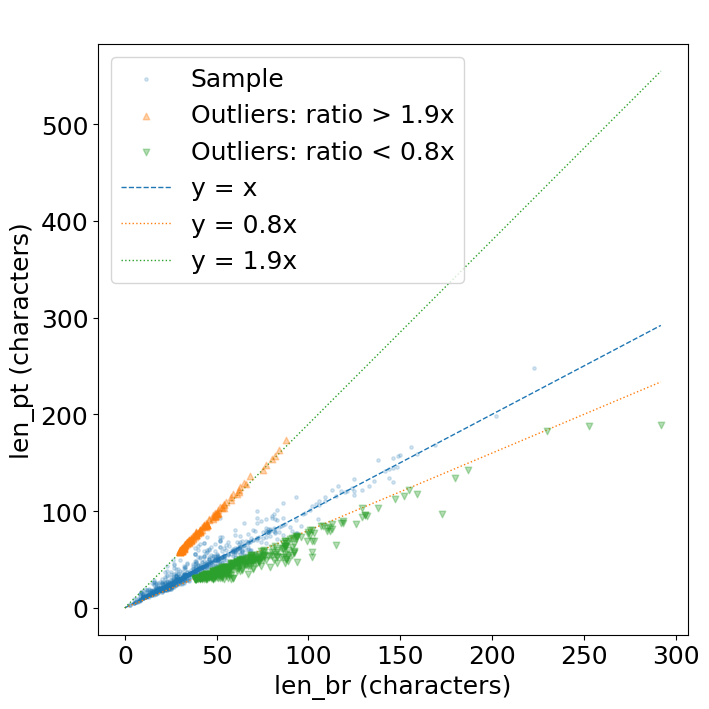

Overlaying 2 outliers on the scatter.


In [12]:
o = plot_scatter_with_outliers(
    scatter_sample=1_000,
    save_path="scatter_outliers.pdf"
)
print(f"Overlaying {len(o)} outliers on the scatter.")

In [16]:
con.execute("""
WITH
r_all AS (
  SELECT
    LENGTH(sent_pt_br) AS lb,
    LENGTH(sent_pt_pt) AS lp,
    (LENGTH(sent_pt_pt)::DOUBLE / NULLIF(LENGTH(sent_pt_br),0)) AS ratio
  FROM opus_moses_filtered
  WHERE sent_pt_br IS NOT NULL AND sent_pt_pt IS NOT NULL AND LENGTH(sent_pt_br) > 0
),
med AS (SELECT QUANTILE_CONT(ratio, 0.5) AS med_r FROM r_all),
dev AS (SELECT ABS(ratio - med.med_r) AS abs_dev FROM r_all, med),
mad AS (SELECT QUANTILE_CONT(abs_dev, 0.5) AS mad_r FROM dev),
scored AS (
  SELECT
    ratio,
    0.6745 * ABS(ratio - med.med_r) / NULLIF(mad.mad_r, 0) AS robust_z
  FROM r_all, med, mad
)
SELECT
  COUNT(*)                                           AS n_rows,
  SUM(ratio < 0.50 OR ratio > 2.00)                  AS n_hard,
  SUM(robust_z >= 3.5)                               AS n_robust,
  SUM((ratio < 0.50 OR ratio > 2.00) AND robust_z >= 3.5) AS n_both,
  SUM((ratio < 0.50 OR ratio > 2.00) OR  robust_z >= 3.5) AS n_union,
  ROUND(100.0 * SUM((ratio < 0.50 OR ratio > 2.00) OR robust_z >= 3.5) / COUNT(*), 3) AS pct_union
FROM scored;

""").fetchdf()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,n_rows,n_hard,n_robust,n_both,n_union,pct_union
0,10510013,162119.0,1324447.0,162119.0,1324447.0,12.602


In [2]:
# --- DELETE OPUS HARD-OUTLIERS (no backup) ---
import duckdb, pathlib

DB_PATH    = "../data/duckdb/subs.duckdb"
OPUS_TABLE = "opus_moses_filtered"   # change if you use a different OPUS table
RATIO_LOW  = 0.50
RATIO_HIGH = 2.00

con = duckdb.connect(DB_PATH)
con.execute("PRAGMA threads=4;")
con.execute("PRAGMA preserve_insertion_order=false;")

# Count before & how many will be deleted
total_before = con.execute(f"SELECT COUNT(*) FROM {OPUS_TABLE}").fetchone()[0]
to_delete = con.execute(f"""
WITH r AS (
  SELECT (LENGTH(sent_pt_pt)::DOUBLE / NULLIF(LENGTH(sent_pt_br),0)) AS ratio
  FROM {OPUS_TABLE}
  WHERE sent_pt_br IS NOT NULL
    AND sent_pt_pt IS NOT NULL
    AND LENGTH(sent_pt_br) > 0
)
SELECT SUM(ratio < {RATIO_LOW} OR ratio > {RATIO_HIGH})::BIGINT
FROM r;
""").fetchone()[0] or 0

print(f"[OPUS] rows before: {total_before:,}")
print(f"[OPUS] hard-limit outliers to delete (<{RATIO_LOW}x or >{RATIO_HIGH}x): {to_delete:,}")

# In-place delete of hard outliers
con.execute(f"""
DELETE FROM {OPUS_TABLE}
WHERE sent_pt_br IS NOT NULL
  AND sent_pt_pt IS NOT NULL
  AND LENGTH(sent_pt_br) > 0
  AND (
        (LENGTH(sent_pt_pt)::DOUBLE / NULLIF(LENGTH(sent_pt_br),0)) < {RATIO_LOW}
     OR (LENGTH(sent_pt_pt)::DOUBLE / NULLIF(LENGTH(sent_pt_br),0)) > {RATIO_HIGH}
  );
""")

total_after = con.execute(f"SELECT COUNT(*) FROM {OPUS_TABLE}").fetchone()[0]
print(f"[OPUS] rows after:  {total_after:,}  (deleted {total_before - total_after:,})")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

[OPUS] rows before: 10,510,013
[OPUS] hard-limit outliers to delete (<0.5x or >2.0x): 162,119
[OPUS] rows after:  10,347,894  (deleted 162,119)
